# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 


## Homework 9:  ANNs


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader<br/>


<hr style="height:2pt">



In [1]:
# RUN THIS CELL FOR FORMAT
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

Import libraries:

In [2]:
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

import keras 
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from keras import regularizers


from sklearn.utils import shuffle

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<hr style='height:2pt'>
<div class='theme'> Neural Networks </div> 

Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In symbols: $ \cal{F(s)} = \int_{-\infty}^\infty f(x)e^{-2\pi i xs}dx$. In words, the value of the transformed function at some point, $s$, is the value of an integral which measures, in some sense, how much the original f(x) looks like a wave with period s. As an example, with $f(x) = 4cos(x) + sin(2x)$,  $\cal{F}(s)$ is 0 everywhere except at -2, -1, 1, and 2, mapping to the waves of period 1 and 1/2. The values at these points are linked to the magnitude of the waves, and their phases (roughly: sin waves versus cosine waves).

The only thing about the Fourier transform that matters for this pset is this: function goes in, re-write in terms of sine and cosine comes out.

In our specific problem, we'll train a network to map from 1000 sample values from a function (equally spaced along 0 to 2$\pi$) to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4.

Questions 1.1 and 1.2 will get you used to the format of the data.

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> <b> Question 1 [50pts] <b> </div>

**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve.

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**1.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [3]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [4]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

### Answers:  

**1.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

(10000, 1000)

Text(0.5,1,'First Row of Training Set')

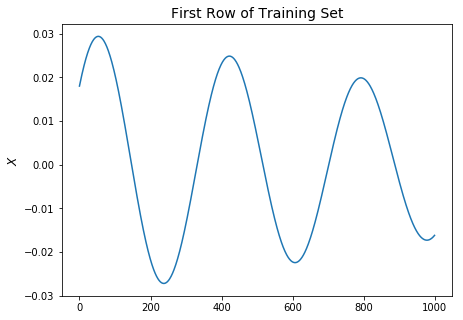

In [5]:
# your code here
display(X_train.shape)
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(X_train[0,], label=r'$X$')
ax.set_ylabel(r'$X$', fontsize=12)
ax.set_title('First Row of Training Set', fontsize=14)

**1.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.024\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

Text(0.5,1,'$f(X)$ for first row')

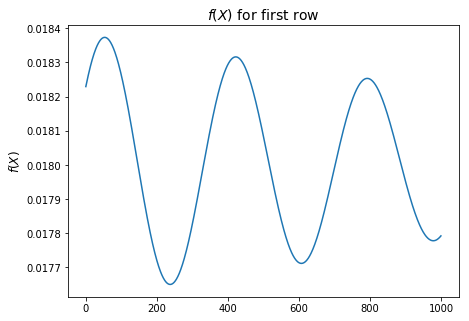

In [6]:
# your code here
f_x = 0.024*np.sin(0.533*X_train[0]) + 0.018*np.cos(0.558*X_train[0])
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.plot(f_x, label=r'$f(X)$')
ax.set_ylabel(r'$f(X)$', fontsize=12)
ax.set_title('$f(X)$ for first row', fontsize=14)

**1.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [7]:
# your code here
H = 150
L = 10
input_dim = 1000 

model = keras.models.Sequential() 

# hidden layers (L)
for i in range(L):
    model.add(keras.layers.Dense(H, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu')) 
# output layer
model.add(keras.layers.Dense(4, kernel_initializer='normal', 
                activation='linear'))

**Answer:**

We use this combination of number of nodes and number of layers, because it gives us a validation error of approximately 0.02 - as desired in the question.

**1.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [8]:
# your code here
model.compile(loss='mean_absolute_error', optimizer='adam')
display(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               150150    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_4 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_5 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_6 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_7 (Dense)              (None, 150)               22650     
__________

None

----
**Answer:**

Each of the input dimensions go into each of the nodes in the first layer. We have 150 nodes in each hidden layer and 1000 input dimensions. So for each of the nodes in the first hidden layer, we have 1 parameter to give the weights for affine transformations for each of the input dimensions going into it and one parameter for the activation function. Thus, we have $150*1000=150000$ total affine transformations + $150$ activation functions = 150150 parameters.  


**1.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [9]:
# your code here
#f_x = y_train[1]*np.sin(0.533*X_train) + 0.018*np.cos(0.558*X_train[0])
model_history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1, \
                          shuffle = True, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 3s 328us/step - loss: 0.2274 - val_loss: 0.2132
Epoch 2/50
8000/8000 [==============================] - 3s 348us/step - loss: 0.1683 - val_loss: 0.1451
Epoch 3/50
8000/8000 [==============================] - 2s 301us/step - loss: 0.1262 - val_loss: 0.1102
Epoch 4/50
8000/8000 [==============================] - 2s 249us/step - loss: 0.0992 - val_loss: 0.0866
Epoch 5/50
8000/8000 [==============================] - 2s 233us/step - loss: 0.0780 - val_loss: 0.0746
Epoch 6/50
8000/8000 [==============================] - 3s 316us/step - loss: 0.0651 - val_loss: 0.0648
Epoch 7/50
8000/8000 [==============================] - 2s 234us/step - loss: 0.0542 - val_loss: 0.0577
Epoch 8/50
8000/8000 [==============================] - 2s 283us/step - loss: 0.0468 - val_loss: 0.0439
Epoch 9/50
8000/8000 [==============================] - 2s 261us/step - loss: 0.0445 - val_loss: 0.0442
Epoch 10/50
8000

Text(0.5,1,'Error as a Function of Epochs')

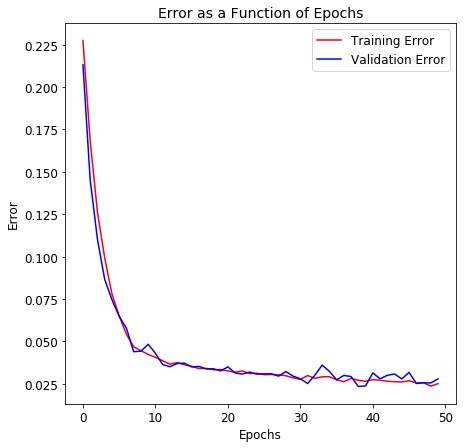

In [10]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.plot(model_history.history['loss'], color='red', label='Training Error')
ax.plot(model_history.history['val_loss'], color='blue', label='Validation Error')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.legend(loc='best', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_title('Error as a Function of Epochs', fontsize=14)

**1.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

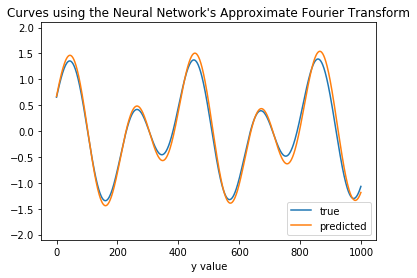

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.9595372  0.9766133  0.6695246  0.48006696]


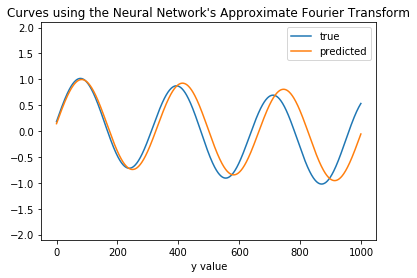

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.85639256 0.6023923  0.1431007  0.08182629]


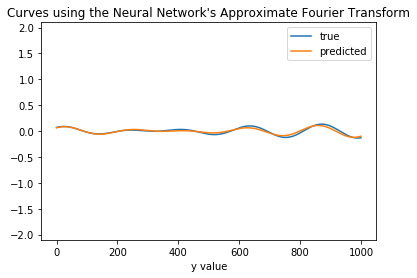

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.06331608 0.77830607 0.06437665 0.9119868 ]


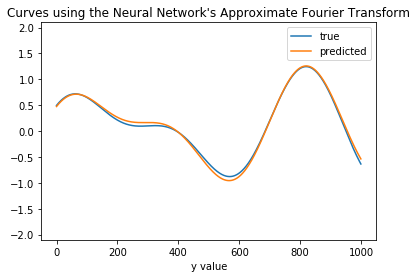

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.78434676 0.30377597 0.4744247  0.48862427]


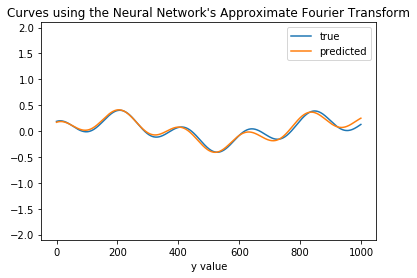

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.24616541 0.2753426  0.16997257 0.9648801 ]


In [11]:
# your code here
plot_predictions(model, test_x=X_test, test_y=y_test)

In [12]:
print('\nTotal loss on the Test Set: %s'%model.evaluate(X_test, y_test))

2000/2000 [==============================] - 0s 78us/step

Total loss on the Test Set: 0.02693744656443596


----
**Answer:**

We see above that our total loss on the test set is 0.027 and which similar to the validation error in the last step of our first network. Thus, it seems that the model is performing pretty well on the test data set. 

**1.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

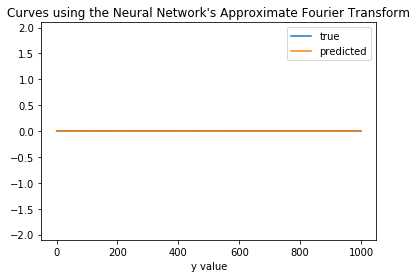

true: [0. 0. 0. 0.]
predicted: [ 0.00442269  0.5893971  -0.00272386  0.53924876]


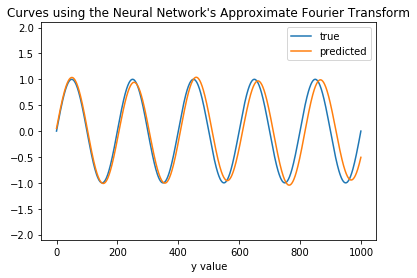

true: [1. 1. 0. 0.]
predicted: [0.9936381  0.9809843  0.05198237 0.4012767 ]


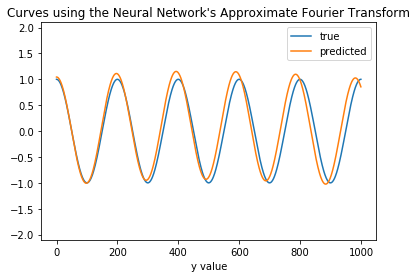

true: [0. 0. 1. 1.]
predicted: [0.11199296 0.10689051 1.04355    1.0181174 ]


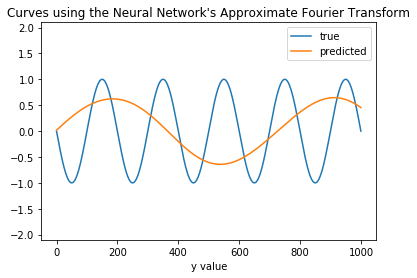

true: [-1.  1.  0.  0.]
predicted: [0.6367775  0.2755617  0.01624243 0.6258744 ]


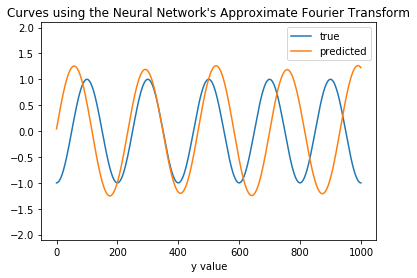

true: [ 0.  0. -1.  1.]
predicted: [1.2249901  0.85803723 0.04229444 0.41388756]


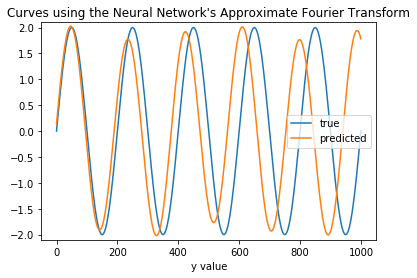

true: [2. 1. 0. 0.]
predicted: [1.9021856  1.0639334  0.14350896 0.36344826]


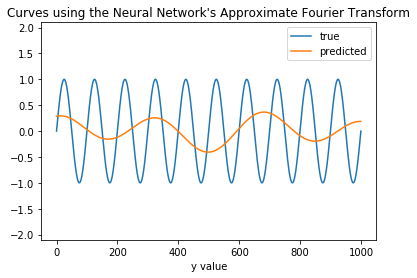

true: [1. 2. 0. 0.]
predicted: [0.13192807 0.32657635 0.28636286 0.5960197 ]


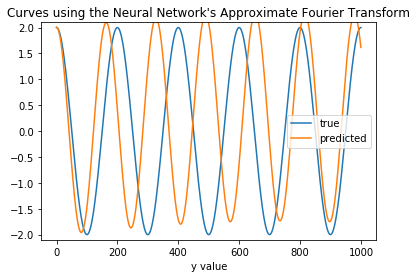

true: [0. 0. 2. 1.]
predicted: [0.27125457 0.06802007 2.0052361  1.2256857 ]


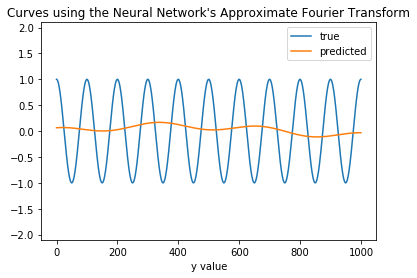

true: [0. 0. 1. 2.]
predicted: [0.10532093 0.1361649  0.06428452 0.5971668 ]


In [13]:
# your code here
plot_predictions(model, test_x=X_extended_test, test_y=y_extended_test)

In [14]:
model.evaluate(X_extended_test, y_extended_test, steps=9)

9/9 [==============================] - 0s 1ms/step


0.44034892320632935

----
**Answer:**

As we can see above the model performs well on samples: (1:3, 5) and struggles with samples: (4, 6:9). Thus, we get a loss that is a lot higher compared to the train or the test set. 

**1.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

---
**Answer:**

We can see that the model is always predicting values for [a,b,c,d] in the range [0,1] - which is what we trained it on. However, the true values in the difficult samples are either $<0$ or $>1$.

This means that the model only learned the mapping from the training set but could not be generalized to the `extended_test` set which had values outside of the training set. Thus, the model was overfit on the train set.

<hr style='height:2pt'>

## Regulrizing Neural Networks

In this problem set we have already explored how ANN are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size), and how well the neural network can generalize. In this problem we focus on issues of overfitting and regularization in Neural Networks.

As we have explained in class, ANNs can be prone to overfitting, where they learn specific patterns present in the training data, but the patterns don't generalize to fresh data.

There are several methods used to improve ANN generalization. One approach is to use an achitecutre just barely wide/deep enough to fit the data. The idea here is that smaller networks are less expressive and thus less able to overfit the data.

However, it is difficult to know a priori the correct size of the ANN, and computationally costly to hunt for a correct size. Given this, other methodologies are used to fight overfitting and improve the ANN generalization. These, like other techniques to combat overfitting, fall under the umbrella of Regularization.

In this problem you are asked to regularize a network given to you below. The train dataset can be generated using the code also given below. 




<div class='exercise'> <b> Question 2 [50 pts] </b> </div>


**2.1 Data Download and Exploration:**  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU 
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 2,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

We will evaluate your model on a test set we've kept secret. 

1. Don't try to use extra data from NMIST. We will re-train your model on training set under the settings above. 
2. Keep the  architecture above as is. In other words keep the number of layers, number of nodes, activation function, and loss fucntion the same. You can change the number of epochs (max 2000), batch size, optimizer and of course add elements that can help to regularize (e.g. drop out, L2 norm etc). You can also do data augmentation. 
3. You *may* import new modules, following the citation rule above.

Grading: Your score will be based on how much you can improve on the test score via regularization:
1.  (0-1] percent will result into 10 pts
2.  (1-2] percent will result into 20 pts
3.  (2-3] percent will result into 30 pts
4.   Above 3 percent will result in 35 pts
6.   Top 15 groups or single students will be awarded an additional 10 pts
7.   The overall winner(s) will be awarded an additional 5 pts

**2.1 Data Download and Exploration**:  For this problem, we will be working with the MNIST dataset (Modified National Institute of Standards and Technology database) which is a large database of handwritten digits and commonly used for training various image processing systems. We will be working directly with the download from `keras MNIST dataset` of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

Please refer to the code below to process the data.

For pedagogical simplicity, we will only use the digits labeled `4` and `9`, and we want to use a total of 800 samples for training.

In [15]:
## Read and Setup train and test splits in one
from keras.datasets import mnist 
from random import randint 

(x_train, y_train), (x_test, y_test) = mnist.load_data() 

#shuffle the data before we do anything
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [16]:
## separating 4s and 9s select 800 points 
# your code here 
display(x_train.shape)
display(y_train.shape)

# mask for 4 & 9
msk_train = ((y_train==4) | (y_train==9))
msk_test = ((y_test==4) | (y_test==9))

# random sampling
rand = []
for i in range(800):
    rand.append(randint(0,msk_train.sum()))


# filter data
y_train_filtered = y_train[msk_train][rand]
x_train_filtered = x_train[msk_train][rand]
y_test_filtered = y_test[msk_test]
x_test_filtered = x_test[msk_test]

(60000, 28, 28)

(60000,)

In [17]:
# sanity check
display(y_train_filtered.shape)
display(x_train_filtered.shape)
display(y_test_filtered.shape)
display(x_test_filtered.shape)

(800,)

(800, 28, 28)

(1991,)

(1991, 28, 28)

In [18]:
# Preprocess data using keras.utils.to_categorical
# your code here 
y_train_clean = keras.utils.to_categorical(y=y_train_filtered.reshape(-1,1), 
                                           num_classes=len(np.unique(y_train)), 
                                           dtype='uint8')[:,[4,9]]
y_test_clean = keras.utils.to_categorical(y=y_test_filtered.reshape(-1,1), 
                                          num_classes=len(np.unique(y_test)),
                                          dtype='uint8')[:,[4,9]]

In [19]:
# scale the data otherwise reLU can become unstable 
# your code here 
from sklearn.preprocessing import StandardScaler

nrow_train = x_train_filtered.shape[0]
nrow_test = x_test_filtered.shape[0]
col = x_train_filtered.shape[1]
depth = x_train_filtered.shape[2]

x_train_reshaped = x_train_filtered.reshape(nrow_train, col*depth)
x_test_reshaped = x_test_filtered.reshape(nrow_test, col*depth)


scaler = StandardScaler().fit(x_train_reshaped)
x_train_clean = scaler.transform(x_train_reshaped)
x_test_clean = scaler.transform(x_test_reshaped)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


**2.2 Data Exploration and Inspection:** Use `imshow` to display a handwritten 4 and a handwritten 9.

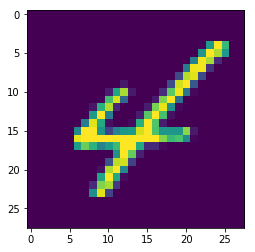

In [20]:
# your code here
plt.imshow(x_train_filtered[y_train_clean[:,0]==1,:,:][5,:,:])

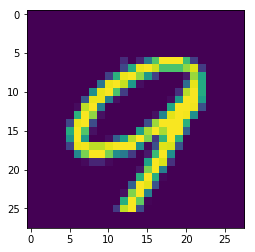

In [21]:
plt.imshow(x_train_filtered[y_train_clean[:,1]==1,:,:][5,:,:])

**2.3 Overfit an ANN:** Build a fully connected network (FCN) using `keras`: 

1. Nodes per Layer: 100,100,100,2 (<-the two-class 'output' layer)
2. Activation function: reLU
3. Loss function: binary_crossentropy
4. Output unit: Sigmoid 
5. Optimizer: sgd (use the defaults; no other tuning)
6. Epochs: no more than 1,000
7. Batch size: 128
8. Validation size: .5

This NN trained on the dataset you built in 2.1 will overfit to the training set. Plot the training accuracy and validation accuracy as a function of epochs and explain how you can tell it is overfitting. 

In [22]:
# your code here
H = 100
L = 3
input_dim = col*depth

In [23]:
model2 = keras.models.Sequential() 

# hidden layers (L)
for i in range(L):
    model2.add(keras.layers.Dense(H, input_dim=input_dim, 
                kernel_initializer='normal', 
                activation='relu')) 
# output layer
model2.add(keras.layers.Dense(2, kernel_initializer='normal', 
                activation='sigmoid'))

# compile
model2.compile(loss='binary_crossentropy', optimizer='sgd')

model2_history = model2.fit(x_train_clean, y_train_clean, batch_size=128, epochs=1000, validation_split=0.5)

Train on 400 samples, validate on 400 samples
Epoch 1/1000
400/400 [==============================] - 0s 753us/step - loss: 0.6941 - val_loss: 0.6952
Epoch 2/1000
400/400 [==============================] - 0s 58us/step - loss: 0.6939 - val_loss: 0.6949
Epoch 3/1000
400/400 [==============================] - 0s 60us/step - loss: 0.6937 - val_loss: 0.6947
Epoch 4/1000
400/400 [==============================] - 0s 98us/step - loss: 0.6935 - val_loss: 0.6945
Epoch 5/1000
400/400 [==============================] - 0s 95us/step - loss: 0.6933 - val_loss: 0.6944
Epoch 6/1000
400/400 [==============================] - 0s 68us/step - loss: 0.6931 - val_loss: 0.6943
Epoch 7/1000
400/400 [==============================] - 0s 98us/step - loss: 0.6929 - val_loss: 0.6942
Epoch 8/1000
400/400 [==============================] - 0s 103us/step - loss: 0.6927 - val_loss: 0.6941
Epoch 9/1000
400/400 [==============================] - 0s 85us/step - loss: 0.6926 - val_loss: 0.6940
Epoch 10/1000
400/400 [==

400/400 [==============================] - 0s 65us/step - loss: 0.4781 - val_loss: 0.5155
Epoch 158/1000
400/400 [==============================] - 0s 60us/step - loss: 0.4714 - val_loss: 0.5100
Epoch 159/1000
400/400 [==============================] - ETA: 0s - loss: 0.477 - 0s 50us/step - loss: 0.4648 - val_loss: 0.5048
Epoch 160/1000
400/400 [==============================] - 0s 60us/step - loss: 0.4582 - val_loss: 0.4992
Epoch 161/1000
400/400 [==============================] - 0s 63us/step - loss: 0.4515 - val_loss: 0.4934
Epoch 162/1000
400/400 [==============================] - 0s 70us/step - loss: 0.4445 - val_loss: 0.4872
Epoch 163/1000
400/400 [==============================] - 0s 58us/step - loss: 0.4374 - val_loss: 0.4810
Epoch 164/1000
400/400 [==============================] - 0s 65us/step - loss: 0.4300 - val_loss: 0.4748
Epoch 165/1000
400/400 [==============================] - 0s 70us/step - loss: 0.4226 - val_loss: 0.4689
Epoch 166/1000
400/400 [======================

Epoch 312/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0239 - val_loss: 0.1572
Epoch 313/1000
400/400 [==============================] - 0s 50us/step - loss: 0.0237 - val_loss: 0.1571
Epoch 314/1000
400/400 [==============================] - 0s 73us/step - loss: 0.0234 - val_loss: 0.1572
Epoch 315/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0231 - val_loss: 0.1570
Epoch 316/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0228 - val_loss: 0.1569
Epoch 317/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0225 - val_loss: 0.1569
Epoch 318/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0222 - val_loss: 0.1567
Epoch 319/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0220 - val_loss: 0.1564
Epoch 320/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0217 - val_loss: 0.1564
Epoch 321/1000
400/400 [==============================]

Epoch 390/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0109 - val_loss: 0.1537
Epoch 391/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0108 - val_loss: 0.1537
Epoch 392/1000
400/400 [==============================] - 0s 95us/step - loss: 0.0107 - val_loss: 0.1537
Epoch 393/1000
400/400 [==============================] - 0s 90us/step - loss: 0.0106 - val_loss: 0.1537
Epoch 394/1000
400/400 [==============================] - 0s 93us/step - loss: 0.0106 - val_loss: 0.1538
Epoch 395/1000
400/400 [==============================] - 0s 95us/step - loss: 0.0105 - val_loss: 0.1537
Epoch 396/1000
400/400 [==============================] - 0s 113us/step - loss: 0.0104 - val_loss: 0.1536
Epoch 397/1000
400/400 [==============================] - 0s 93us/step - loss: 0.0103 - val_loss: 0.1536
Epoch 398/1000
400/400 [==============================] - 0s 88us/step - loss: 0.0102 - val_loss: 0.1536
Epoch 399/1000
400/400 [==============================

Epoch 468/1000
400/400 [==============================] - 0s 50us/step - loss: 0.0064 - val_loss: 0.1532
Epoch 469/1000
400/400 [==============================] - 0s 55us/step - loss: 0.0063 - val_loss: 0.1533
Epoch 470/1000
400/400 [==============================] - 0s 48us/step - loss: 0.0063 - val_loss: 0.1533
Epoch 471/1000
400/400 [==============================] - 0s 73us/step - loss: 0.0063 - val_loss: 0.1533
Epoch 472/1000
400/400 [==============================] - 0s 65us/step - loss: 0.0062 - val_loss: 0.1533
Epoch 473/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0062 - val_loss: 0.1533
Epoch 474/1000
400/400 [==============================] - 0s 73us/step - loss: 0.0062 - val_loss: 0.1533
Epoch 475/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0061 - val_loss: 0.1533
Epoch 476/1000
400/400 [==============================] - 0s 48us/step - loss: 0.0061 - val_loss: 0.1532
Epoch 477/1000
400/400 [==============================]

Epoch 546/1000
400/400 [==============================] - 0s 58us/step - loss: 0.0043 - val_loss: 0.1539
Epoch 547/1000
400/400 [==============================] - 0s 53us/step - loss: 0.0043 - val_loss: 0.1539
Epoch 548/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0043 - val_loss: 0.1539
Epoch 549/1000
400/400 [==============================] - 0s 65us/step - loss: 0.0042 - val_loss: 0.1539
Epoch 550/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0042 - val_loss: 0.1539
Epoch 551/1000
400/400 [==============================] - 0s 58us/step - loss: 0.0042 - val_loss: 0.1539
Epoch 552/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0042 - val_loss: 0.1540
Epoch 553/1000
400/400 [==============================] - 0s 65us/step - loss: 0.0042 - val_loss: 0.1540
Epoch 554/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0042 - val_loss: 0.1539
Epoch 555/1000
400/400 [==============================]

400/400 [==============================] - 0s 63us/step - loss: 0.0031 - val_loss: 0.1552
Epoch 625/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0031 - val_loss: 0.1552
Epoch 626/1000
400/400 [==============================] - 0s 50us/step - loss: 0.0031 - val_loss: 0.1553
Epoch 627/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0031 - val_loss: 0.1553
Epoch 628/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0031 - val_loss: 0.1553
Epoch 629/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0031 - val_loss: 0.1554
Epoch 630/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0031 - val_loss: 0.1553
Epoch 631/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0031 - val_loss: 0.1554
Epoch 632/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0031 - val_loss: 0.1554
Epoch 633/1000
400/400 [==============================] - 0s 63us/step

Epoch 702/1000
400/400 [==============================] - 0s 65us/step - loss: 0.0024 - val_loss: 0.1565
Epoch 703/1000
400/400 [==============================] - 0s 50us/step - loss: 0.0024 - val_loss: 0.1565
Epoch 704/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0024 - val_loss: 0.1566
Epoch 705/1000
400/400 [==============================] - 0s 58us/step - loss: 0.0024 - val_loss: 0.1566
Epoch 706/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0024 - val_loss: 0.1566
Epoch 707/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0024 - val_loss: 0.1566
Epoch 708/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0024 - val_loss: 0.1566
Epoch 709/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0024 - val_loss: 0.1566
Epoch 710/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0024 - val_loss: 0.1567
Epoch 711/1000
400/400 [==============================]

Epoch 780/1000
400/400 [==============================] - 0s 58us/step - loss: 0.0020 - val_loss: 0.1576
Epoch 781/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0020 - val_loss: 0.1576
Epoch 782/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0020 - val_loss: 0.1577
Epoch 783/1000
400/400 [==============================] - 0s 75us/step - loss: 0.0019 - val_loss: 0.1577
Epoch 784/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0019 - val_loss: 0.1577
Epoch 785/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0019 - val_loss: 0.1578
Epoch 786/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0019 - val_loss: 0.1578
Epoch 787/1000
400/400 [==============================] - 0s 65us/step - loss: 0.0019 - val_loss: 0.1578
Epoch 788/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0019 - val_loss: 0.1578
Epoch 789/1000
400/400 [==============================]

Epoch 858/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0016 - val_loss: 0.1588
Epoch 859/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0016 - val_loss: 0.1588
Epoch 860/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0016 - val_loss: 0.1588
Epoch 861/1000
400/400 [==============================] - 0s 78us/step - loss: 0.0016 - val_loss: 0.1589
Epoch 862/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0016 - val_loss: 0.1589
Epoch 863/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0016 - val_loss: 0.1589
Epoch 864/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0016 - val_loss: 0.1589
Epoch 865/1000
400/400 [==============================] - 0s 60us/step - loss: 0.0016 - val_loss: 0.1589
Epoch 866/1000
400/400 [==============================] - 0s 63us/step - loss: 0.0016 - val_loss: 0.1590
Epoch 867/1000
400/400 [==============================]

Epoch 936/1000
400/400 [==============================] - 0s 55us/step - loss: 0.0014 - val_loss: 0.1600
Epoch 937/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0014 - val_loss: 0.1600
Epoch 938/1000
400/400 [==============================] - 0s 68us/step - loss: 0.0014 - val_loss: 0.1601
Epoch 939/1000
400/400 [==============================] - 0s 70us/step - loss: 0.0014 - val_loss: 0.1601
Epoch 940/1000
400/400 [==============================] - 0s 80us/step - loss: 0.0014 - val_loss: 0.1601
Epoch 941/1000
400/400 [==============================] - 0s 83us/step - loss: 0.0014 - val_loss: 0.1601
Epoch 942/1000
400/400 [==============================] - 0s 85us/step - loss: 0.0014 - val_loss: 0.1601
Epoch 943/1000
400/400 [==============================] - 0s 93us/step - loss: 0.0014 - val_loss: 0.1601
Epoch 944/1000
400/400 [==============================] - 0s 73us/step - loss: 0.0014 - val_loss: 0.1601
Epoch 945/1000
400/400 [==============================]

Text(0.5,1,'Error as a Function of Epochs')

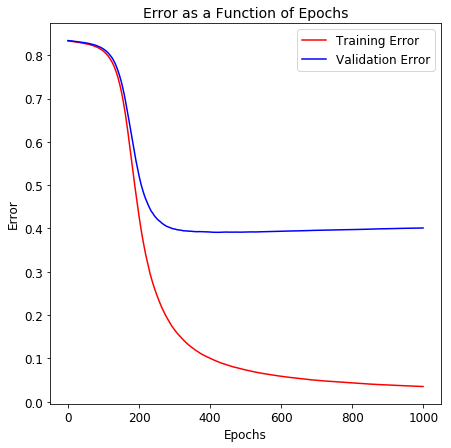

In [24]:
#your code here
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.plot(np.sqrt(model2_history.history['loss']), color='red', label='Training Error')
ax.plot(np.sqrt(model2_history.history['val_loss']), color='blue', label='Validation Error')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.legend(loc='best', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_title('Error as a Function of Epochs', fontsize=14)

In [25]:
y_pred = model2.predict_classes(x_test_clean)
model2_acc = accuracy_score(y_test_clean[:,1], y_pred)
model2_acc

0.9417378201908588

<hr>

**Answer:**

As we can we in the above plot that the trainig error is decreasing with the increase in the number of epochs but the validation error is more or less remaining constant or rather increasing slightly. In short, the training error and validation error are diverging from each other which tells us that the model is clearly overfitting.


**2.4 Explore Regularization**: Your task is to regularize this FCN. You are free to explore any method or combination of methods. If you are using anything besides the methods we have covered in class, give a citation and a short explanation. You should always have an understanding of the methods you are using. 

Save the model using `model.save(filename)` and submit in canvas along with your notebook. 

In [26]:
model3 = keras.models.Sequential() 

# hidden layers (L)
model3.add(keras.layers.Dense(H, input_dim=input_dim,
                              kernel_initializer='normal',
                              bias_regularizer=regularizers.l2(0.01),
                              kernel_regularizer=regularizers.l2(0.01),
                              activation='relu'))

# output layer
model3.add(keras.layers.Dense(2, kernel_initializer='normal',
                              activity_regularizer=regularizers.l2(0.01),
                              activation='sigmoid'))

# compile
model3.compile(loss='binary_crossentropy', optimizer='sgd')

model3_history = model3.fit(x_train_clean, y_train_clean, batch_size=150, epochs=2000, 
                            validation_split=0.2, verbose=1)

Train on 640 samples, validate on 160 samples
Epoch 1/2000
640/640 [==============================] - 0s 461us/step - loss: 3.4316 - val_loss: 3.2794
Epoch 2/2000
640/640 [==============================] - 0s 40us/step - loss: 3.2461 - val_loss: 3.1566
Epoch 3/2000
640/640 [==============================] - 0s 36us/step - loss: 3.1377 - val_loss: 3.0837
Epoch 4/2000
640/640 [==============================] - 0s 44us/step - loss: 3.0728 - val_loss: 3.0380
Epoch 5/2000
640/640 [==============================] - 0s 47us/step - loss: 3.0308 - val_loss: 3.0074
Epoch 6/2000
640/640 [==============================] - 0s 50us/step - loss: 3.0009 - val_loss: 2.9840
Epoch 7/2000
640/640 [==============================] - 0s 45us/step - loss: 2.9771 - val_loss: 2.9658
Epoch 8/2000
640/640 [==============================] - 0s 34us/step - loss: 2.9564 - val_loss: 2.9499
Epoch 9/2000
640/640 [==============================] - 0s 34us/step - loss: 2.9411 - val_loss: 2.9359
Epoch 10/2000
640/640 [===

Epoch 79/2000
640/640 [==============================] - 0s 50us/step - loss: 2.4666 - val_loss: 2.4996
Epoch 80/2000
640/640 [==============================] - 0s 63us/step - loss: 2.4625 - val_loss: 2.4956
Epoch 81/2000
640/640 [==============================] - 0s 69us/step - loss: 2.4590 - val_loss: 2.4917
Epoch 82/2000
640/640 [==============================] - 0s 53us/step - loss: 2.4540 - val_loss: 2.4878
Epoch 83/2000
640/640 [==============================] - 0s 52us/step - loss: 2.4494 - val_loss: 2.4839
Epoch 84/2000
640/640 [==============================] - 0s 56us/step - loss: 2.4462 - val_loss: 2.4801
Epoch 85/2000
640/640 [==============================] - 0s 53us/step - loss: 2.4414 - val_loss: 2.4763
Epoch 86/2000
640/640 [==============================] - 0s 61us/step - loss: 2.4392 - val_loss: 2.4724
Epoch 87/2000
640/640 [==============================] - 0s 50us/step - loss: 2.4341 - val_loss: 2.4687
Epoch 88/2000
640/640 [==============================] - 0s 63us

640/640 [==============================] - 0s 45us/step - loss: 1.9714 - val_loss: 2.0249
Epoch 235/2000
640/640 [==============================] - 0s 36us/step - loss: 1.9691 - val_loss: 2.0224
Epoch 236/2000
640/640 [==============================] - 0s 33us/step - loss: 1.9668 - val_loss: 2.0198
Epoch 237/2000
640/640 [==============================] - 0s 50us/step - loss: 1.9639 - val_loss: 2.0170
Epoch 238/2000
640/640 [==============================] - 0s 53us/step - loss: 1.9611 - val_loss: 2.0145
Epoch 239/2000
640/640 [==============================] - 0s 34us/step - loss: 1.9589 - val_loss: 2.0121
Epoch 240/2000
640/640 [==============================] - 0s 48us/step - loss: 1.9563 - val_loss: 2.0097
Epoch 241/2000
640/640 [==============================] - 0s 41us/step - loss: 1.9528 - val_loss: 2.0073
Epoch 242/2000
640/640 [==============================] - 0s 50us/step - loss: 1.9509 - val_loss: 2.0047
Epoch 243/2000
640/640 [==============================] - 0s 44us/step

Epoch 312/2000
640/640 [==============================] - 0s 45us/step - loss: 1.7859 - val_loss: 1.8441
Epoch 313/2000
640/640 [==============================] - 0s 33us/step - loss: 1.7837 - val_loss: 1.8422
Epoch 314/2000
640/640 [==============================] - 0s 50us/step - loss: 1.7824 - val_loss: 1.8400
Epoch 315/2000
640/640 [==============================] - 0s 50us/step - loss: 1.7793 - val_loss: 1.8377
Epoch 316/2000
640/640 [==============================] - 0s 34us/step - loss: 1.7778 - val_loss: 1.8353
Epoch 317/2000
640/640 [==============================] - ETA: 0s - loss: 1.785 - 0s 56us/step - loss: 1.7753 - val_loss: 1.8333
Epoch 318/2000
640/640 [==============================] - 0s 33us/step - loss: 1.7730 - val_loss: 1.8311
Epoch 319/2000
640/640 [==============================] - 0s 44us/step - loss: 1.7706 - val_loss: 1.8290
Epoch 320/2000
640/640 [==============================] - 0s 44us/step - loss: 1.7692 - val_loss: 1.8269
Epoch 321/2000
640/640 [=======

Epoch 390/2000
640/640 [==============================] - 0s 45us/step - loss: 1.6303 - val_loss: 1.6897
Epoch 391/2000
640/640 [==============================] - 0s 44us/step - loss: 1.6273 - val_loss: 1.6878
Epoch 392/2000
640/640 [==============================] - 0s 39us/step - loss: 1.6261 - val_loss: 1.6857
Epoch 393/2000
640/640 [==============================] - 0s 52us/step - loss: 1.6238 - val_loss: 1.6838
Epoch 394/2000
640/640 [==============================] - 0s 59us/step - loss: 1.6221 - val_loss: 1.6819
Epoch 395/2000
640/640 [==============================] - 0s 56us/step - loss: 1.6196 - val_loss: 1.6802
Epoch 396/2000
640/640 [==============================] - 0s 70us/step - loss: 1.6189 - val_loss: 1.6783
Epoch 397/2000
640/640 [==============================] - 0s 75us/step - loss: 1.6164 - val_loss: 1.6766
Epoch 398/2000
640/640 [==============================] - 0s 64us/step - loss: 1.6157 - val_loss: 1.6748
Epoch 399/2000
640/640 [==============================]

640/640 [==============================] - 0s 39us/step - loss: 1.4961 - val_loss: 1.5568
Epoch 469/2000
640/640 [==============================] - 0s 41us/step - loss: 1.4947 - val_loss: 1.5552
Epoch 470/2000
640/640 [==============================] - 0s 52us/step - loss: 1.4934 - val_loss: 1.5535
Epoch 471/2000
640/640 [==============================] - 0s 45us/step - loss: 1.4916 - val_loss: 1.5520
Epoch 472/2000
640/640 [==============================] - 0s 47us/step - loss: 1.4899 - val_loss: 1.5504
Epoch 473/2000
640/640 [==============================] - 0s 48us/step - loss: 1.4887 - val_loss: 1.5489
Epoch 474/2000
640/640 [==============================] - 0s 44us/step - loss: 1.4872 - val_loss: 1.5473
Epoch 475/2000
640/640 [==============================] - 0s 50us/step - loss: 1.4851 - val_loss: 1.5458
Epoch 476/2000
640/640 [==============================] - 0s 31us/step - loss: 1.4828 - val_loss: 1.5443
Epoch 477/2000
640/640 [==============================] - 0s 53us/step

Epoch 546/2000
640/640 [==============================] - 0s 41us/step - loss: 1.3828 - val_loss: 1.4435
Epoch 547/2000
640/640 [==============================] - 0s 42us/step - loss: 1.3814 - val_loss: 1.4421
Epoch 548/2000
640/640 [==============================] - 0s 41us/step - loss: 1.3802 - val_loss: 1.4409
Epoch 549/2000
640/640 [==============================] - 0s 44us/step - loss: 1.3786 - val_loss: 1.4395
Epoch 550/2000
640/640 [==============================] - 0s 50us/step - loss: 1.3781 - val_loss: 1.4382
Epoch 551/2000
640/640 [==============================] - 0s 44us/step - loss: 1.3762 - val_loss: 1.4369
Epoch 552/2000
640/640 [==============================] - 0s 42us/step - loss: 1.3753 - val_loss: 1.4355
Epoch 553/2000
640/640 [==============================] - 0s 50us/step - loss: 1.3739 - val_loss: 1.4341
Epoch 554/2000
640/640 [==============================] - 0s 41us/step - loss: 1.3717 - val_loss: 1.4328
Epoch 555/2000
640/640 [==============================]

Epoch 701/2000
640/640 [==============================] - 0s 42us/step - loss: 1.2043 - val_loss: 1.2638
Epoch 702/2000
640/640 [==============================] - 0s 41us/step - loss: 1.2033 - val_loss: 1.2627
Epoch 703/2000
640/640 [==============================] - 0s 48us/step - loss: 1.2026 - val_loss: 1.2615
Epoch 704/2000
640/640 [==============================] - 0s 45us/step - loss: 1.2014 - val_loss: 1.2606
Epoch 705/2000
640/640 [==============================] - 0s 48us/step - loss: 1.2007 - val_loss: 1.2596
Epoch 706/2000
640/640 [==============================] - 0s 47us/step - loss: 1.1996 - val_loss: 1.2584
Epoch 707/2000
640/640 [==============================] - 0s 42us/step - loss: 1.1986 - val_loss: 1.2575
Epoch 708/2000
640/640 [==============================] - 0s 50us/step - loss: 1.1978 - val_loss: 1.2565
Epoch 709/2000
640/640 [==============================] - 0s 31us/step - loss: 1.1967 - val_loss: 1.2557
Epoch 710/2000
640/640 [==============================]

Epoch 779/2000
640/640 [==============================] - 0s 33us/step - loss: 1.1338 - val_loss: 1.1916
Epoch 780/2000
640/640 [==============================] - 0s 41us/step - loss: 1.1334 - val_loss: 1.1908
Epoch 781/2000
640/640 [==============================] - 0s 47us/step - loss: 1.1320 - val_loss: 1.1898
Epoch 782/2000
640/640 [==============================] - 0s 53us/step - loss: 1.1309 - val_loss: 1.1888
Epoch 783/2000
640/640 [==============================] - 0s 50us/step - loss: 1.1300 - val_loss: 1.1880
Epoch 784/2000
640/640 [==============================] - 0s 47us/step - loss: 1.1293 - val_loss: 1.1873
Epoch 785/2000
640/640 [==============================] - 0s 48us/step - loss: 1.1285 - val_loss: 1.1862
Epoch 786/2000
640/640 [==============================] - 0s 33us/step - loss: 1.1276 - val_loss: 1.1852
Epoch 787/2000
640/640 [==============================] - 0s 42us/step - loss: 1.1276 - val_loss: 1.1845
Epoch 788/2000
640/640 [==============================]

Epoch 857/2000
640/640 [==============================] - 0s 44us/step - loss: 1.0727 - val_loss: 1.1299
Epoch 858/2000
640/640 [==============================] - 0s 33us/step - loss: 1.0727 - val_loss: 1.1291
Epoch 859/2000
640/640 [==============================] - 0s 48us/step - loss: 1.0715 - val_loss: 1.1283
Epoch 860/2000
640/640 [==============================] - 0s 45us/step - loss: 1.0710 - val_loss: 1.1276
Epoch 861/2000
640/640 [==============================] - 0s 47us/step - loss: 1.0699 - val_loss: 1.1270
Epoch 862/2000
640/640 [==============================] - 0s 50us/step - loss: 1.0695 - val_loss: 1.1263
Epoch 863/2000
640/640 [==============================] - 0s 33us/step - loss: 1.0689 - val_loss: 1.1256
Epoch 864/2000
640/640 [==============================] - 0s 42us/step - loss: 1.0679 - val_loss: 1.1249
Epoch 865/2000
640/640 [==============================] - 0s 47us/step - loss: 1.0676 - val_loss: 1.1243
Epoch 866/2000
640/640 [==============================]

Epoch 1012/2000
640/640 [==============================] - 0s 39us/step - loss: 0.9773 - val_loss: 1.0323
Epoch 1013/2000
640/640 [==============================] - 0s 31us/step - loss: 0.9769 - val_loss: 1.0320
Epoch 1014/2000
640/640 [==============================] - 0s 47us/step - loss: 0.9766 - val_loss: 1.0315
Epoch 1015/2000
640/640 [==============================] - 0s 47us/step - loss: 0.9762 - val_loss: 1.0310
Epoch 1016/2000
640/640 [==============================] - 0s 45us/step - loss: 0.9756 - val_loss: 1.0305
Epoch 1017/2000
640/640 [==============================] - 0s 45us/step - loss: 0.9749 - val_loss: 1.0299
Epoch 1018/2000
640/640 [==============================] - 0s 44us/step - loss: 0.9744 - val_loss: 1.0295
Epoch 1019/2000
640/640 [==============================] - 0s 41us/step - loss: 0.9736 - val_loss: 1.0289
Epoch 1020/2000
640/640 [==============================] - 0s 47us/step - loss: 0.9737 - val_loss: 1.0285
Epoch 1021/2000
640/640 [=====================

640/640 [==============================] - 0s 42us/step - loss: 0.9396 - val_loss: 0.9945
Epoch 1090/2000
640/640 [==============================] - 0s 41us/step - loss: 0.9398 - val_loss: 0.9939
Epoch 1091/2000
640/640 [==============================] - 0s 42us/step - loss: 0.9387 - val_loss: 0.9934
Epoch 1092/2000
640/640 [==============================] - 0s 55us/step - loss: 0.9387 - val_loss: 0.9930
Epoch 1093/2000
640/640 [==============================] - 0s 48us/step - loss: 0.9385 - val_loss: 0.9927
Epoch 1094/2000
640/640 [==============================] - 0s 53us/step - loss: 0.9381 - val_loss: 0.9922
Epoch 1095/2000
640/640 [==============================] - 0s 47us/step - loss: 0.9375 - val_loss: 0.9915
Epoch 1096/2000
640/640 [==============================] - 0s 52us/step - loss: 0.9366 - val_loss: 0.9914
Epoch 1097/2000
640/640 [==============================] - 0s 48us/step - loss: 0.9363 - val_loss: 0.9909
Epoch 1098/2000
640/640 [==============================] - 0s 

640/640 [==============================] - 0s 34us/step - loss: 0.8797 - val_loss: 0.9321
Epoch 1244/2000
640/640 [==============================] - 0s 39us/step - loss: 0.8795 - val_loss: 0.9315
Epoch 1245/2000
640/640 [==============================] - 0s 36us/step - loss: 0.8791 - val_loss: 0.9311
Epoch 1246/2000
640/640 [==============================] - 0s 53us/step - loss: 0.8790 - val_loss: 0.9308
Epoch 1247/2000
640/640 [==============================] - 0s 42us/step - loss: 0.8785 - val_loss: 0.9305
Epoch 1248/2000
640/640 [==============================] - 0s 42us/step - loss: 0.8786 - val_loss: 0.9302
Epoch 1249/2000
640/640 [==============================] - 0s 50us/step - loss: 0.8778 - val_loss: 0.9300
Epoch 1250/2000
640/640 [==============================] - 0s 52us/step - loss: 0.8779 - val_loss: 0.9297
Epoch 1251/2000
640/640 [==============================] - 0s 53us/step - loss: 0.8769 - val_loss: 0.9293
Epoch 1252/2000
640/640 [==============================] - 0s 

Epoch 1397/2000
640/640 [==============================] - 0s 55us/step - loss: 0.8357 - val_loss: 0.8854
Epoch 1398/2000
640/640 [==============================] - 0s 77us/step - loss: 0.8351 - val_loss: 0.8854
Epoch 1399/2000
640/640 [==============================] - 0s 48us/step - loss: 0.8353 - val_loss: 0.8850
Epoch 1400/2000
640/640 [==============================] - 0s 45us/step - loss: 0.8347 - val_loss: 0.8851
Epoch 1401/2000
640/640 [==============================] - 0s 52us/step - loss: 0.8349 - val_loss: 0.8847
Epoch 1402/2000
640/640 [==============================] - 0s 42us/step - loss: 0.8348 - val_loss: 0.8845
Epoch 1403/2000
640/640 [==============================] - 0s 42us/step - loss: 0.8344 - val_loss: 0.8842
Epoch 1404/2000
640/640 [==============================] - 0s 59us/step - loss: 0.8338 - val_loss: 0.8840
Epoch 1405/2000
640/640 [==============================] - 0s 55us/step - loss: 0.8337 - val_loss: 0.8836
Epoch 1406/2000
640/640 [=====================

640/640 [==============================] - 0s 41us/step - loss: 0.8032 - val_loss: 0.8516
Epoch 1552/2000
640/640 [==============================] - 0s 39us/step - loss: 0.8025 - val_loss: 0.8515
Epoch 1553/2000
640/640 [==============================] - 0s 41us/step - loss: 0.8024 - val_loss: 0.8513
Epoch 1554/2000
640/640 [==============================] - 0s 42us/step - loss: 0.8023 - val_loss: 0.8512
Epoch 1555/2000
640/640 [==============================] - 0s 42us/step - loss: 0.8019 - val_loss: 0.8513
Epoch 1556/2000
640/640 [==============================] - 0s 45us/step - loss: 0.8019 - val_loss: 0.8514
Epoch 1557/2000
640/640 [==============================] - 0s 39us/step - loss: 0.8020 - val_loss: 0.8513
Epoch 1558/2000
640/640 [==============================] - 0s 48us/step - loss: 0.8015 - val_loss: 0.8511
Epoch 1559/2000
640/640 [==============================] - 0s 48us/step - loss: 0.8013 - val_loss: 0.8507
Epoch 1560/2000
640/640 [==============================] - 0s 

640/640 [==============================] - 0s 55us/step - loss: 0.7786 - val_loss: 0.8266
Epoch 1706/2000
640/640 [==============================] - 0s 50us/step - loss: 0.7787 - val_loss: 0.8265
Epoch 1707/2000
640/640 [==============================] - 0s 50us/step - loss: 0.7784 - val_loss: 0.8263
Epoch 1708/2000
640/640 [==============================] - 0s 45us/step - loss: 0.7782 - val_loss: 0.8262
Epoch 1709/2000
640/640 [==============================] - 0s 45us/step - loss: 0.7784 - val_loss: 0.8260
Epoch 1710/2000
640/640 [==============================] - 0s 55us/step - loss: 0.7778 - val_loss: 0.8258
Epoch 1711/2000
640/640 [==============================] - 0s 53us/step - loss: 0.7778 - val_loss: 0.8259
Epoch 1712/2000
640/640 [==============================] - 0s 53us/step - loss: 0.7778 - val_loss: 0.8257
Epoch 1713/2000
640/640 [==============================] - 0s 55us/step - loss: 0.7777 - val_loss: 0.8254
Epoch 1714/2000
640/640 [==============================] - 0s 

Epoch 1782/2000
640/640 [==============================] - 0s 38us/step - loss: 0.7689 - val_loss: 0.8166
Epoch 1783/2000
640/640 [==============================] - 0s 36us/step - loss: 0.7692 - val_loss: 0.8164
Epoch 1784/2000
640/640 [==============================] - 0s 52us/step - loss: 0.7687 - val_loss: 0.8161
Epoch 1785/2000
640/640 [==============================] - 0s 45us/step - loss: 0.7683 - val_loss: 0.8159
Epoch 1786/2000
640/640 [==============================] - 0s 45us/step - loss: 0.7684 - val_loss: 0.8158
Epoch 1787/2000
640/640 [==============================] - 0s 45us/step - loss: 0.7685 - val_loss: 0.8159
Epoch 1788/2000
640/640 [==============================] - 0s 44us/step - loss: 0.7687 - val_loss: 0.8157
Epoch 1789/2000
640/640 [==============================] - 0s 42us/step - loss: 0.7681 - val_loss: 0.8154
Epoch 1790/2000
640/640 [==============================] - 0s 50us/step - loss: 0.7683 - val_loss: 0.8154
Epoch 1791/2000
640/640 [=====================

640/640 [==============================] - 0s 36us/step - loss: 0.7534 - val_loss: 0.8000
Epoch 1937/2000
640/640 [==============================] - 0s 41us/step - loss: 0.7534 - val_loss: 0.7997
Epoch 1938/2000
640/640 [==============================] - 0s 39us/step - loss: 0.7532 - val_loss: 0.7996
Epoch 1939/2000
640/640 [==============================] - 0s 47us/step - loss: 0.7532 - val_loss: 0.7995
Epoch 1940/2000
640/640 [==============================] - 0s 47us/step - loss: 0.7533 - val_loss: 0.7995
Epoch 1941/2000
640/640 [==============================] - 0s 31us/step - loss: 0.7529 - val_loss: 0.7992
Epoch 1942/2000
640/640 [==============================] - 0s 44us/step - loss: 0.7527 - val_loss: 0.7991
Epoch 1943/2000
640/640 [==============================] - 0s 33us/step - loss: 0.7531 - val_loss: 0.7990
Epoch 1944/2000
640/640 [==============================] - 0s 39us/step - loss: 0.7528 - val_loss: 0.7990
Epoch 1945/2000
640/640 [==============================] - 0s 

In [27]:
y_pred = model3.predict_classes(x_test_clean)
model3_acc = accuracy_score(y_test_clean[:,1], y_pred)
model3_acc

0.9698643897538926

Text(0.5,1,'Error as a Function of Epochs')

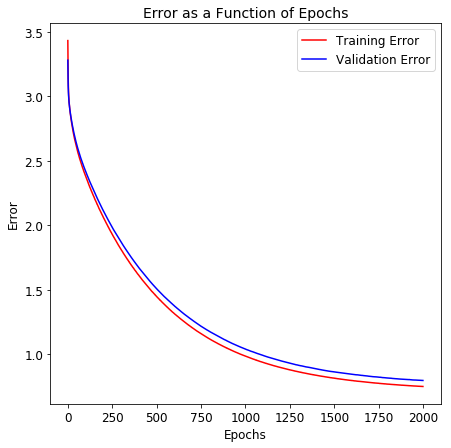

In [28]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.plot(model3_history.history['loss'], color='red', label='Training Error')
ax.plot(model3_history.history['val_loss'], color='blue', label='Validation Error')
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Error', fontsize=12)
ax.legend(loc='best', fontsize=12)
ax.tick_params(labelsize=12)
ax.set_title('Error as a Function of Epochs', fontsize=14)

In [29]:
model3.save('cs109_HW9_Q2_4.h5')

In [30]:
from keras.models import load_model
m = load_model('cs109_HW9_Q2_4.h5')
y_pred = m.predict_classes(x_test_clean)
m_acc = accuracy_score(y_test_clean[:,1], y_pred)
m_acc

0.9698643897538926

**Answer:**

Keeping the architecture same as 2.3, the following methods were tried for regularization: `Dropout`, `L1`, `L2`, `Sparse Representation`. Of those, we find that `Dropout` gives almost the same accuracy as the original model and `L1` gives a much lower accuracy on the test set. Hence, after much trial and error, the following regularization combination was used:
1. `L2` on `kernel` ($\lambda = 0.015$) and `bias` ($\lambda = 0.015$) of the hidden layers (i.e. `Sparse Representation`) and 
2. `L2` on activation function ($\lambda = 0.015$) of the output layer

In addition, the following changes were made to the model in 2.3:
1. batch_size=150,
2. epochs=2000,
3. validation_split=0.2